In [1]:
from utils.dataloader import DataPartitions, DataGenerator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/home/diego/Study/Tesi Laurea/models/utils/dataloader.py:249: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if accesses is not 0:


In [29]:
# sequences: array(
#   (x:Array, y:Dictionary)
# )
#
partitions = DataPartitions(
    past_frames=6,
    future_frames=1,
    root="../datasets/arda/04_21_full/",
    partial=0.1
)

In [3]:
dataset = DataGenerator(
    root="../datasets/arda/04_21_full/", 
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 128, 128, 3),
    output_dim=(partitions.future_frames, 128, 128, 1),
    batch_size=4,
    n_channels=1,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
)

In [4]:
X = dataset.get_X()
Y = dataset.get_Y()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0

100%|██████████| 216/216 [02:43<00:00,  1.32it/s]


0.7485206638841324


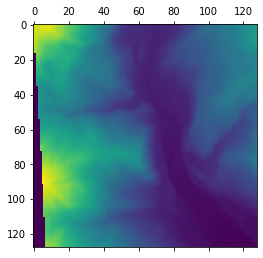

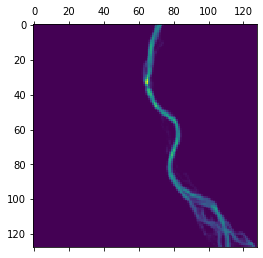

In [5]:
print(dataset.buffer_hit_ratio)

i = 3
j = 5

plt.matshow(X[j, i, 0, :, :, 2])

plt.matshow(X[j, i, 0, :, :, 0])
#plt.matshow(X[j, i, 2, :, :, 0])
#plt.matshow(X[j, i, 4, :, :, 0])
#plt.matshow(Y[j, i, 0, :, :, 0])

In [6]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [95]:
print("DEP min: {}\nVEL min: {}\nBTM min: {}".format(
    np.min(X_train[:, :, :, :, :, 0]),
    np.min(X_train[:, :, :, :, :, 1]),
    np.min(X_train[:, :, :, :, :, 2])
))

print("DEP max: {}\nVEL max: {}\nBTM max: {}".format(
    np.max(X_train[:, :, :, :, :, 0]),
    np.max(X_train[:, :, :, :, :, 1]),
    np.max(X_train[:, :, :, :, :, 2])
))

DEP min: 0.0
VEL min: 0.0
BTM min: 0.0
DEP max: 3.7295258984375
VEL max: 6.083452645246397
BTM max: 175.12394140625


### Model

In [96]:
import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

In [97]:
if th.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = th.device(dev) 

In [98]:
class ResNetBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride, kernel_size, padding):
        super(ResNetBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.Conv3d(in_filters, filters, kernel_size, stride, padding=padding)
        self.c2 = nn.Conv3d(filters, filters, kernel_size, padding=padding)
        self.c3 = nn.Conv3d(in_filters, filters, (1, 1, 1), stride)
        
        #self.bn = nn.BatchNorm3d(num_features=filters)

    def forward(self, x,):
        
        residual = x
        
        y = self.c1(x)

        #y = self.bn(y)
        y = self.activation(y)
        y = self.c2(y)
        #y = self.bn(y)

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            #residual = self.bn(residual)
            
        return self.activation(residual + y)


In [99]:
class Autoencoder(nn.Module):
    
    def __init__(self, channels):
        super(Autoencoder, self).__init__()

        kernel_size = 3
        padding = 1

        self.layers = nn.ModuleList([
            nn.Conv3d(channels, 8, kernel_size=kernel_size, stride=1, padding=padding),
            nn.AvgPool3d((1,2,2)),
            
            ResNetBlock(in_filters = 8, filters = 8, stride = 2, kernel_size=kernel_size, padding=padding),

            nn.Conv3d(8, 16, (1,1,1)),
            ResNetBlock(in_filters = 16, filters = 16, stride = 2, kernel_size=kernel_size, padding=padding),

            nn.Conv3d(16, 32, (1,1,1)),
            ResNetBlock(in_filters = 32, filters = 32, stride = (2,1,1), kernel_size=kernel_size, padding=padding),

            nn.Conv3d(32, 64, (1,1,1)),
            ResNetBlock(in_filters = 64, filters = 64, stride = 1, kernel_size=kernel_size, padding=padding),

            # ----------------------

            nn.ConvTranspose3d(64, 32, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=32),

            nn.ConvTranspose3d(32, 16, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=16),

            nn.ConvTranspose3d(16, 8, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=8),

            nn.ConvTranspose3d(8, 8, (1,1,1), stride=(1,1,1)),
            #nn.BatchNorm3d(num_features=8),
            
            nn.ConvTranspose3d(8, 1, (1,1,1), stride=(1,1,1)),
        ])
    
    def forward(self, x, summary = False):
        
        if summary:
            print("==== Model Summary ====")
            print("{:<15s}{:>4s}".format("Block", "Output shape"))

        for i, l in enumerate(self.layers):
            x = l(x)
            
            if summary:
                print("{:<20s}{:>4s}".format(
                    str(l).split("(")[0],
                    str(x.shape).split("[")[1].split("]")[0]
                ))
        
        return x

In [100]:
def xavier_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        th.nn.init.xavier_uniform(m.weight.data)

def sqrt_weights(m):
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [101]:
net = Autoencoder(channels=3).to(device)
net(th.Tensor(np.random.random((16, 3, 6, 128, 128))).to(device), True).shape

==== Model Summary ====
Block          Output shape
Conv3d              16, 8, 6, 128, 128
AvgPool3d           16, 8, 6, 64, 64
ResNetBlock         16, 8, 3, 32, 32
Conv3d              16, 16, 3, 32, 32
ResNetBlock         16, 16, 2, 16, 16
Conv3d              16, 32, 2, 16, 16
ResNetBlock         16, 32, 1, 16, 16
Conv3d              16, 64, 1, 16, 16
ResNetBlock         16, 64, 1, 16, 16
ConvTranspose3d     16, 32, 1, 32, 32
ConvTranspose3d     16, 16, 1, 64, 64
ConvTranspose3d     16, 8, 1, 128, 128
ConvTranspose3d     16, 8, 1, 128, 128
ConvTranspose3d     16, 1, 1, 128, 128


torch.Size([16, 1, 1, 128, 128])

In [102]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [103]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [104]:
X_train = X_train.permute(0, 1, 5, 2, 3, 4)
y_train = y_train.permute(0, 1, 5, 2, 3, 4)

In [105]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [106]:
X_test = X_test.permute(0, 1, 5, 2, 3, 4)
y_test = y_test.permute(0, 1, 5, 2, 3, 4)

In [107]:
def relative_error(y, y_true):
    return (th.norm(y - y_true, float('inf')) / th.norm(y_true, float('inf')))

In [108]:
losses = []
errors = []
test_errors = []

[0,    10] train_err: 1.002 	  test_err: 1.013 	 avg_loss: 0.046


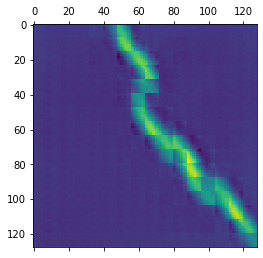

[1,    35] train_err: 1.003 	  test_err: 0.997 	 avg_loss: 0.033
[2,     6] train_err: 1.320 	  test_err: 1.001 	 avg_loss: 0.027
[3,    17] train_err: 0.792 	  test_err: 1.001 	 avg_loss: 0.023


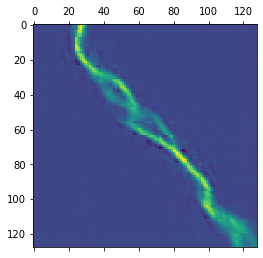

[4,     5] train_err: 1.000 	  test_err: 0.995 	 avg_loss: 0.020
[5,    37] train_err: 1.004 	  test_err: 0.999 	 avg_loss: 0.018
[6,    43] train_err: 0.998 	  test_err: 1.152 	 avg_loss: 0.016


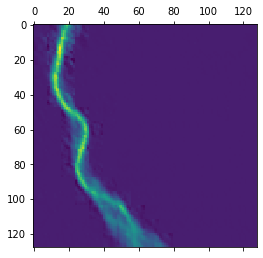

[7,    29] train_err: 1.001 	  test_err: 1.001 	 avg_loss: 0.015
[8,    15] train_err: 1.075 	  test_err: 1.000 	 avg_loss: 0.014
[9,    18] train_err: 0.999 	  test_err: 0.982 	 avg_loss: 0.013


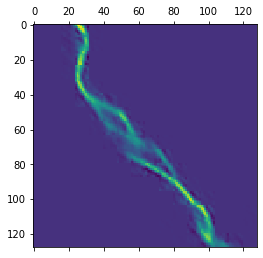

[10,     3] train_err: 1.359 	  test_err: 0.999 	 avg_loss: 0.012
[11,    37] train_err: 1.003 	  test_err: 0.999 	 avg_loss: 0.012
[12,    10] train_err: 1.000 	  test_err: 1.429 	 avg_loss: 0.011


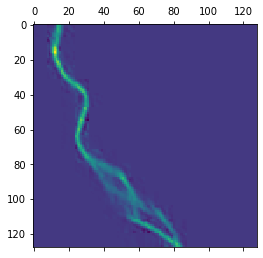

[13,    32] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.011
[14,    21] train_err: 1.000 	  test_err: 0.980 	 avg_loss: 0.010
[15,    27] train_err: 0.999 	  test_err: 0.999 	 avg_loss: 0.010


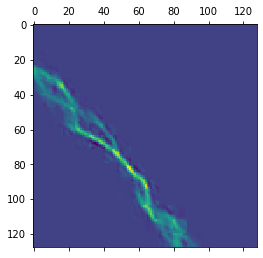

[16,    38] train_err: 1.329 	  test_err: 0.999 	 avg_loss: 0.010
[17,    32] train_err: 1.011 	  test_err: 0.999 	 avg_loss: 0.009
[18,    37] train_err: 0.995 	  test_err: 0.999 	 avg_loss: 0.009


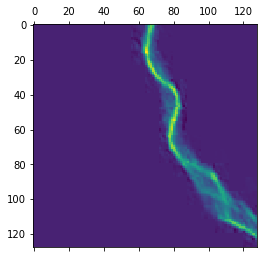

[19,    34] train_err: 1.000 	  test_err: 2.152 	 avg_loss: 0.009
[20,    22] train_err: 1.124 	  test_err: 0.999 	 avg_loss: 0.008
[21,    16] train_err: 1.352 	  test_err: 1.000 	 avg_loss: 0.008


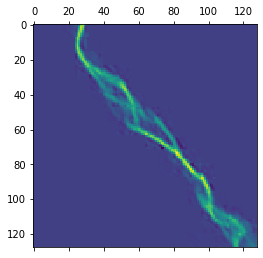

[22,    39] train_err: 1.000 	  test_err: 1.092 	 avg_loss: 0.008
[23,    30] train_err: 1.286 	  test_err: 1.011 	 avg_loss: 0.008
[24,    31] train_err: 1.000 	  test_err: 0.937 	 avg_loss: 0.007


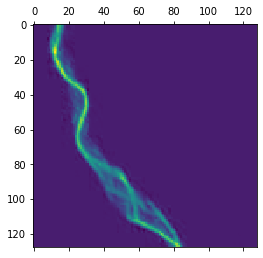

[25,     9] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.007
[26,     2] train_err: 1.000 	  test_err: 1.880 	 avg_loss: 0.007
[27,    37] train_err: 1.031 	  test_err: 1.046 	 avg_loss: 0.007


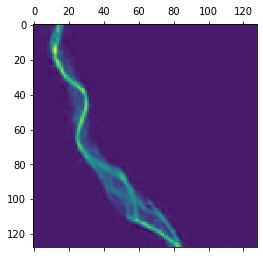

[28,     0] train_err: 0.993 	  test_err: 1.069 	 avg_loss: 0.007
[29,    38] train_err: 1.175 	  test_err: 1.001 	 avg_loss: 0.007
[30,    33] train_err: 0.978 	  test_err: 1.093 	 avg_loss: 0.007


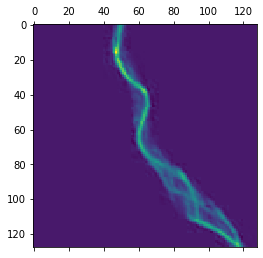

[31,    43] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.007
[32,    33] train_err: 0.978 	  test_err: 1.245 	 avg_loss: 0.006
[33,     6] train_err: 1.549 	  test_err: 1.000 	 avg_loss: 0.006


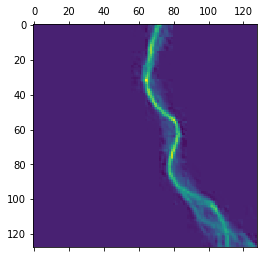

[34,    43] train_err: 1.000 	  test_err: 1.046 	 avg_loss: 0.006
[35,    15] train_err: 1.120 	  test_err: 1.000 	 avg_loss: 0.006
[36,    26] train_err: 1.000 	  test_err: 0.994 	 avg_loss: 0.006


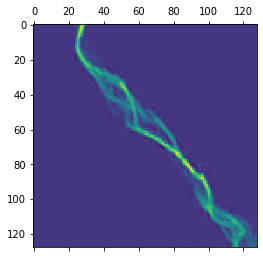

[37,     1] train_err: 1.000 	  test_err: 1.073 	 avg_loss: 0.006
[38,     9] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.006
[39,     4] train_err: 1.000 	  test_err: 1.263 	 avg_loss: 0.006


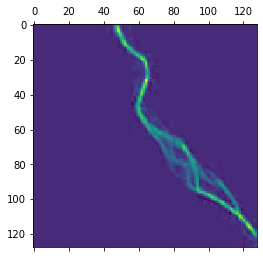

[40,    24] train_err: 1.272 	  test_err: 0.838 	 avg_loss: 0.006
[41,     2] train_err: 0.998 	  test_err: 1.817 	 avg_loss: 0.006
[42,    42] train_err: 1.222 	  test_err: 1.000 	 avg_loss: 0.005


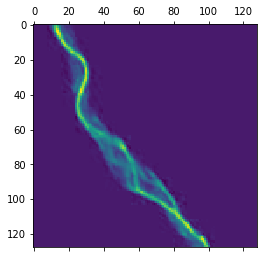

[43,    18] train_err: 1.000 	  test_err: 0.984 	 avg_loss: 0.005
[44,    31] train_err: 0.999 	  test_err: 0.875 	 avg_loss: 0.005
[45,     6] train_err: 1.634 	  test_err: 1.000 	 avg_loss: 0.005


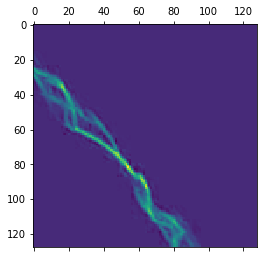

[46,     5] train_err: 1.021 	  test_err: 1.000 	 avg_loss: 0.005
[47,    14] train_err: 1.040 	  test_err: 1.000 	 avg_loss: 0.005
[48,     5] train_err: 1.086 	  test_err: 1.000 	 avg_loss: 0.005


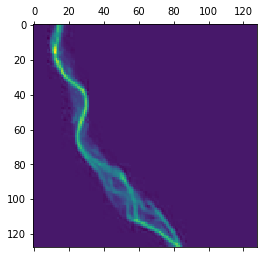

[49,    10] train_err: 1.000 	  test_err: 1.593 	 avg_loss: 0.005
[50,    29] train_err: 1.000 	  test_err: 1.045 	 avg_loss: 0.005
[51,    27] train_err: 1.000 	  test_err: 1.165 	 avg_loss: 0.005


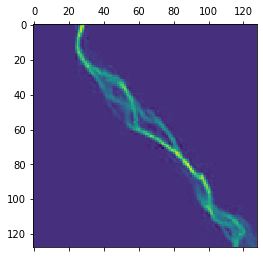

[52,    40] train_err: 1.006 	  test_err: 1.000 	 avg_loss: 0.005
[53,     5] train_err: 1.034 	  test_err: 1.001 	 avg_loss: 0.005
[54,    23] train_err: 1.016 	  test_err: 1.601 	 avg_loss: 0.005


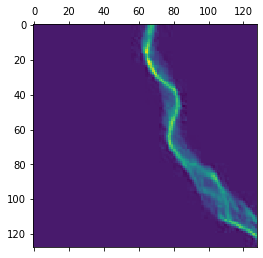

[55,    19] train_err: 1.000 	  test_err: 1.001 	 avg_loss: 0.005
[56,    23] train_err: 1.019 	  test_err: 1.687 	 avg_loss: 0.005
[57,     7] train_err: 1.592 	  test_err: 0.827 	 avg_loss: 0.005


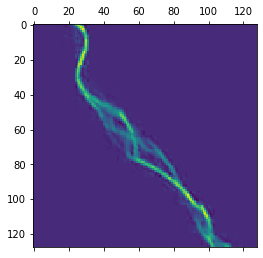

[58,     2] train_err: 1.000 	  test_err: 1.865 	 avg_loss: 0.005
[59,    33] train_err: 0.978 	  test_err: 1.105 	 avg_loss: 0.004
[60,    38] train_err: 1.353 	  test_err: 1.000 	 avg_loss: 0.004


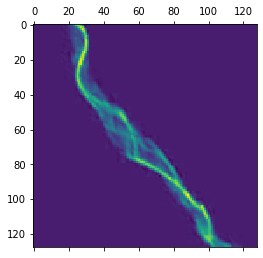

[61,    29] train_err: 1.000 	  test_err: 1.048 	 avg_loss: 0.004
[62,    16] train_err: 1.254 	  test_err: 1.000 	 avg_loss: 0.004
[63,     0] train_err: 1.005 	  test_err: 1.139 	 avg_loss: 0.004


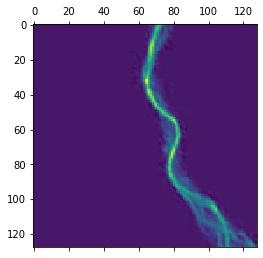

[64,     7] train_err: 1.581 	  test_err: 0.827 	 avg_loss: 0.004
[65,    25] train_err: 1.000 	  test_err: 1.124 	 avg_loss: 0.004
[66,     7] train_err: 1.640 	  test_err: 0.826 	 avg_loss: 0.004


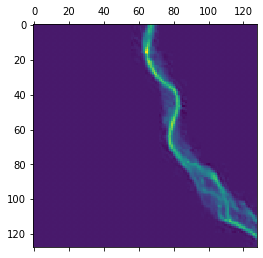

[67,    36] train_err: 1.231 	  test_err: 1.001 	 avg_loss: 0.004
[68,    34] train_err: 1.000 	  test_err: 2.008 	 avg_loss: 0.004
[69,     9] train_err: 1.001 	  test_err: 1.066 	 avg_loss: 0.004


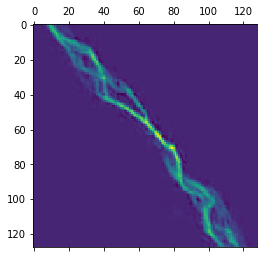

[70,     4] train_err: 1.000 	  test_err: 1.118 	 avg_loss: 0.004
[71,    43] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.004
[72,     4] train_err: 1.000 	  test_err: 1.326 	 avg_loss: 0.004


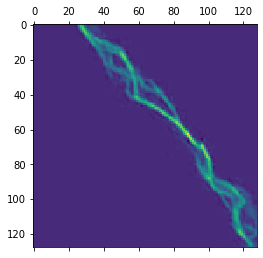

[73,     1] train_err: 1.000 	  test_err: 1.146 	 avg_loss: 0.004
[74,    29] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.004
[75,    43] train_err: 1.000 	  test_err: 1.075 	 avg_loss: 0.004


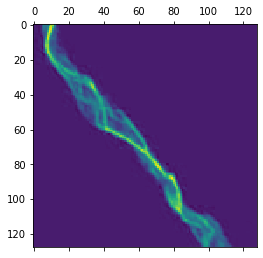

[76,    24] train_err: 1.401 	  test_err: 0.831 	 avg_loss: 0.004
[77,     3] train_err: 1.535 	  test_err: 1.000 	 avg_loss: 0.004
[78,    24] train_err: 1.479 	  test_err: 0.833 	 avg_loss: 0.004


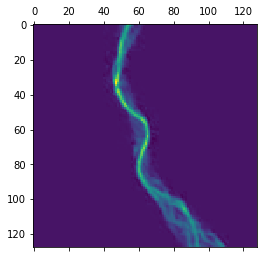

[79,    42] train_err: 1.276 	  test_err: 1.000 	 avg_loss: 0.004
[80,    31] train_err: 1.000 	  test_err: 0.985 	 avg_loss: 0.004
[81,    31] train_err: 1.000 	  test_err: 0.988 	 avg_loss: 0.004


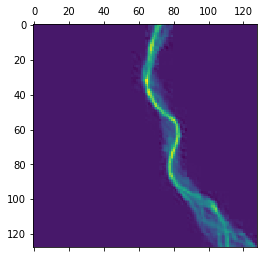

[82,    16] train_err: 1.234 	  test_err: 1.000 	 avg_loss: 0.004
[83,    15] train_err: 1.204 	  test_err: 1.000 	 avg_loss: 0.004
[84,     6] train_err: 1.601 	  test_err: 1.000 	 avg_loss: 0.004


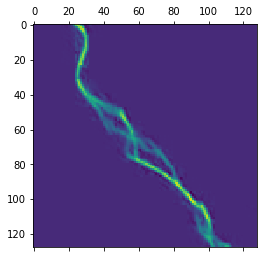

[85,    16] train_err: 1.257 	  test_err: 0.999 	 avg_loss: 0.004
[86,    39] train_err: 0.999 	  test_err: 1.275 	 avg_loss: 0.004
[87,     0] train_err: 1.025 	  test_err: 1.234 	 avg_loss: 0.004


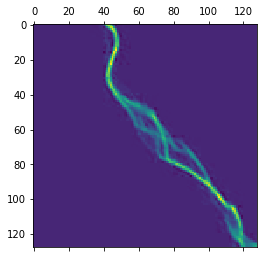

[88,     2] train_err: 1.000 	  test_err: 1.906 	 avg_loss: 0.004
[89,    38] train_err: 1.227 	  test_err: 1.000 	 avg_loss: 0.004
[90,     5] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.004


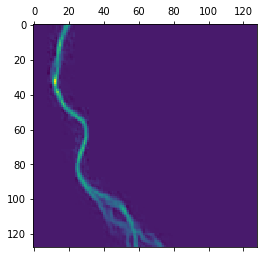

[91,    12] train_err: 1.042 	  test_err: 1.000 	 avg_loss: 0.004
[92,    27] train_err: 1.000 	  test_err: 1.124 	 avg_loss: 0.003
[93,    33] train_err: 0.984 	  test_err: 1.077 	 avg_loss: 0.003


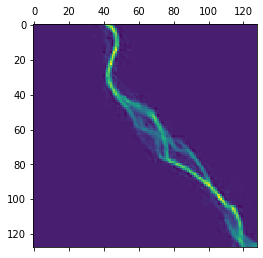

[94,    21] train_err: 1.065 	  test_err: 1.008 	 avg_loss: 0.003
[95,    37] train_err: 0.995 	  test_err: 1.000 	 avg_loss: 0.003
[96,     3] train_err: 1.573 	  test_err: 1.000 	 avg_loss: 0.003


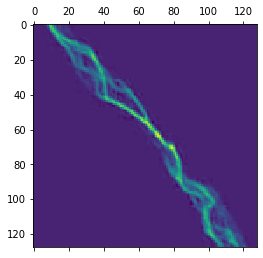

[97,    37] train_err: 0.997 	  test_err: 1.001 	 avg_loss: 0.003
[98,    23] train_err: 1.017 	  test_err: 1.754 	 avg_loss: 0.003
[99,     7] train_err: 1.587 	  test_err: 0.831 	 avg_loss: 0.003


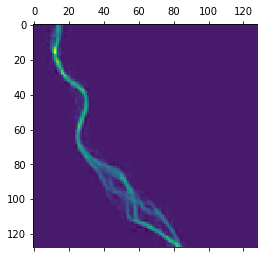

Finished Training


In [109]:
epochs = 100

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        outputs = net(batch)
        
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        losses.append(loss.item())

        # print("batch {} - loss {}".format(i, loss.item()))

        if i == len(X_train)-1:
            # randomly pick a test batch and compute it
            i = np.random.randint(len(y_test), size=1)
            
            train_out = net(X_test[i][0])
            test_out = net(X_train[i][0])
            
            train_err = relative_error(train_out, y_train[i]).item()
            test_err = relative_error(test_out, y_test[i]).item()
        
            test_errors.append(test_err)
            errors.append(train_err)
            
            print('[%d, %5d] train_err: %.3f \t  test_err: %.3f \t avg_loss: %.3f' %
                  (epoch, i, train_err, test_err, np.mean(losses)))

    if epoch % 3 == 0:
        i = np.random.randint(len(X_test))
        outputs = net(X_test[i])
        for frame in outputs[0][0]:
            plt.matshow(frame.cpu().detach().numpy())
            plt.show()

        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

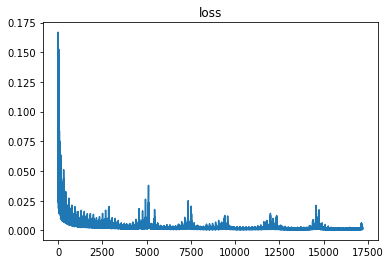

In [110]:
plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

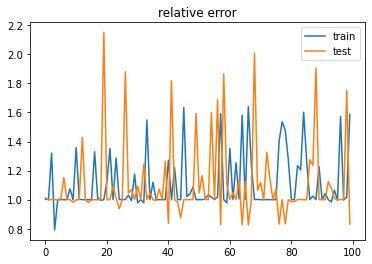

In [111]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass


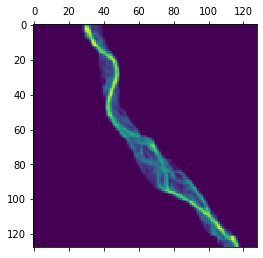

In [112]:
i = np.random.randint(len(X_test))
outputs = net(X_test[i])
for frame in y_test[i][0][0]:
    plt.matshow(frame.cpu().detach().numpy())

torch.Size([4, 1, 1, 128, 128])


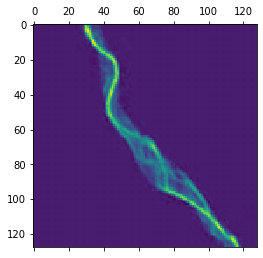

In [113]:
print(outputs.shape)
for frame in outputs[0][0]:
    plt.matshow(frame.cpu().detach().numpy())


[0.09108053]

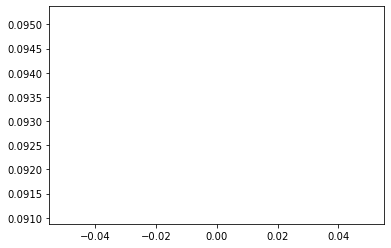

In [114]:
frames = len(outputs[0][0])
plt.plot(range(frames), [np.average(x.cpu().detach().numpy()) for x in y_test[i][0][0]])
plt.plot(range(frames), [np.average(x.cpu().detach().numpy()) for x in outputs[0][0]])
[np.average(x.cpu().detach().numpy()) for x in outputs[0][0]]

In [115]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))

                    min                 max                 mean                std                 
prediction          -0.213688           3.056696            0.107016            0.363393            
true                0.000000            2.937483            0.096938            0.338359            
